In [1]:
from fastai2.vision.all import *
import fastai2

import pdb
import torchvision
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold

In [6]:
import pandas as pd
import numpy as np
import random
import geopandas as gpd
import rasterio
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [3]:
df = pd.read_csv('Train.csv')

test = pd.read_csv('Test.csv')
test.head(3)
# Sample submission:
ss = pd.read_csv('SampleSubmission.csv')
ss.head(3)

,ID,Label
0,00MZGKU,0
1,015JA41,0
2,01POB64,0


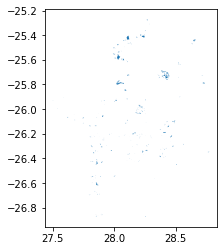

In [4]:
gp = gpd.read_file('GP_Informal_settlement2017.shp')
gp.plot()

In [7]:
from shapely.geometry import Polygon, Point
lats = []
lons = []
labels = []
for i in tqdm(range(200000)):
    lon = 28 + random.random()*0.5
    lat = -26 + random.random()*0.5
    p = Point(lon, lat)
    IN = False
    for geom in gp.geometry:
        if p.within(geom):
            IN = True
    lats.append(lat)
    lons.append(lon)
    labels.append(IN)
ls = pd.DataFrame({
    'LAT':lats,
    'LON':lons,
    'Label':labels
})
ls.sample(10)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


,LAT,LON,Label
181761,-25.685283,28.254652,False
1034,-25.778925,28.202040,False
159293,-25.941177,28.119601,False
193744,-25.603109,28.433747,False
11347,-25.580792,28.425297,False
181829,-25.885806,28.189847,False
141566,-25.877530,28.015866,False
71340,-25.754717,28.235745,False
32486,-25.934348,28.297571,False
122340,-25.544260,28.080623,False


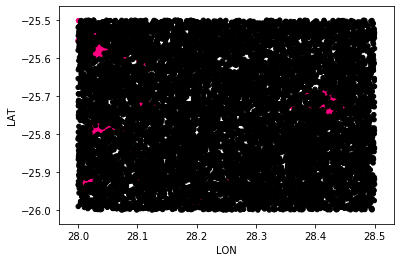

In [8]:
l_sample = pd.concat([ls.loc[ls.Label==True], ls.loc[ls.Label==False].sample(frac=0.05)])
l_sample.plot(kind='scatter', x='LON', y='LAT', c=l_sample['Label'].map(lambda x: (1, 0, 0.5) if x else (0, 0, 0)))

In [9]:
l_sample['ID']='ID'+l_sample.index.astype(str)

In [18]:
df=pd.concat([df,l_sample])
df.shape

(16590, 4)

In [19]:
df.Label.value_counts()

False    13065
True      3525
Name: Label, dtype: int64

In [12]:
dataset = rasterio.open('2528C.tif') 
# Load bands into RAM
red, green, blue = dataset.read(1), dataset.read(2), dataset.read(3)
# Load bands into RAM

# # Let's do 5 points for now - use df.values to do this for the whole dataset
for ID, lat, lon, label in df.sample(5).values:
    
    # Blank image
    im = np.zeros((200,200,3), np.uint8)
    
    # Get pixel coords
    row, col = dataset.index(lon, lat)
    
    # Add image data
    for i, band in enumerate([red, green, blue]):
        im[:,:,i] = band[row-100:row+100, col-100:col+100]
    
    # Save with the location in the name
    im = Image.fromarray(im)
    pth = 'small_images/negative/'
    if label == True:
        pth = 'small_images/positive/'
    im.save(pth+f"im_{ID}_{lat}_{lon}.jpeg")

In [20]:
bad_IDs = []
for i,x in df.iterrows():
    row, col = dataset.index(x['LON'],x['LAT'])
    if band[row-100:row+100, col-100:col+100].shape != (200,200):
#         print(lon,lat)
        bad_IDs.append(x['ID'])

In [21]:
df = df[~df['ID'].isin(list(set(bad_IDs)))]

In [22]:
df['Label'].value_counts()

False    12922
True      3520
Name: Label, dtype: int64

In [23]:
# Get the image:
# random_seed(42)
def get_x(ID):
    row = df.loc[df.ID == ID]
    lat, lon = row['LAT'].values[0], row['LON'].values[0]
    im = np.zeros((200,200,3), np.uint8)
    row, col = dataset.index(lon, lat)
    for i, band in enumerate([red, green, blue]):
        im[:,:,i] = band[row-100:row+100, col-100:col+100]
    
    return im

# And the label
def get_y(ID):
    row = df.loc[df.ID == ID]
    return int(row['Label'].values[0])

# Get the list of Image IDS:
def get_im_ids(path):
    return df.ID.values


def get_data(fold_id,folds,size,bs):
# test_img = ImageList.from_df(test_df, path=data_folder, folder='images')
    tfms = [IntToFloatTensor(div_mask=200),Rotate(4),Flip(),Brightness(0.5,p=0.25),Zoom(max_zoom=1.1,p=0.25)]
    # And build the datablock
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_im_ids,
        get_x=get_x,
        get_y=get_y, 
        splitter=KFSplitter(fold_id=fold_id,folds=folds),
        batch_tfms=tfms,
        item_tfms=[Resize(size)]
    )
    dls = dblock.dataloaders(Path(''), bs=bs)
    return dls


In [25]:
path = Path('./small_images/')
bs = 64
kf = 10
kfold = KFold(n_splits=kf, shuffle=True, random_state=42)
folds = list(kfold.split(X=[x for x in df['ID']]))
len(folds)
# folds

10

In [26]:
def KFSplitter(fold_id,folds,**kwargs):
    def _inner(o,**kwargs):
        return folds[fold_id]

In [27]:
dls = get_data(fold_id=0,folds=folds,size=200,bs=16)

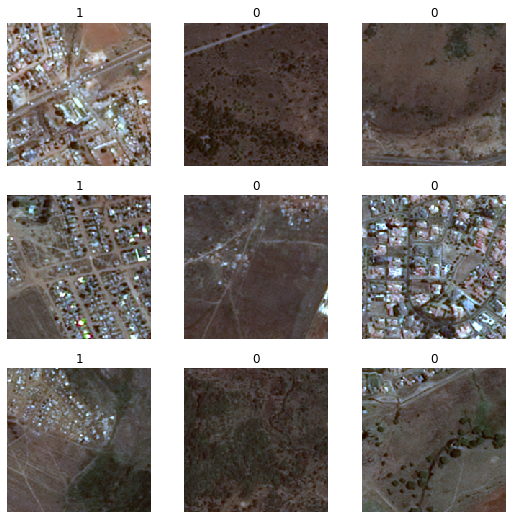

In [28]:
dls.show_batch()

In [29]:
# kf

In [30]:

for fold_id in range(kf):
    dls = dls = get_data(fold_id=fold_id,folds=folds,size=200,bs=16)
    learn = cnn_learner(dls, resnet34, metrics=[error_rate,accuracy])
    learn.fine_tune(1)
    learn.save(f'model-{fold_id}')

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.220147,0.147675,0.049574,0.950426,02:03


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.103334,0.055787,0.020377,0.979623,02:53


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.213689,0.098124,0.035888,0.964112,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.095075,0.055717,0.017032,0.982968,02:53


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.210503,0.123215,0.044708,0.955292,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.110639,0.054315,0.019769,0.980231,02:53


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.188090,0.123347,0.040754,0.959246,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.108551,0.054752,0.020073,0.979927,02:53


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.212582,0.113100,0.041667,0.958333,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.097585,0.045927,0.013686,0.986314,02:53


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.211088,0.115919,0.041971,0.958029,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.092035,0.052049,0.019161,0.980839,02:53


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.223427,0.142483,0.050487,0.949513,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.104495,0.056614,0.020681,0.979319,02:53


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.198811,0.130520,0.051095,0.948905,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.092262,0.064637,0.023723,0.976277,02:53


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.237393,0.134285,0.049878,0.950122,02:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.091305,0.060046,0.024331,0.975669,02:54


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.180788,0.138067,0.044100,0.955900,02:03


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.088070,0.063527,0.024027,0.975973,02:54


In [31]:
test.shape

(2613, 3)

In [32]:
dataset = rasterio.open('2930D.tif') # We'll use rasterio for all raster operations

In [33]:
red, green, blue = dataset.read(1), dataset.read(2), dataset.read(3)

In [34]:
test['Label']=0
df=pd.concat([df,test])

In [35]:
idx = test['ID'].values
tdl = learn.dls.test_dl(idx)

In [36]:
# tdl = learn.dls.test_dl(idx)


In [37]:

def get_k_fold_preds(kf,sz=200):
    preds = []
    for fold_id in tqdm(range(kf)):
        learn.load(f'model-{fold_id}')
        test_preds = array(learn.tta(dl=tdl)[0][:,1])
        preds.append(test_preds)
        
    return preds

In [38]:
preds = get_k_fold_preds(kf)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
np.mean(preds,0)

array([0.02253955, 0.08277476, 0.21907806, ..., 0.703441  , 0.10731751,
       0.01347088], dtype=float32)

In [40]:
test['Label']=np.mean(preds,0)
test

,ID,LAT,LON,Label
0,00MZGKU,-29.8920,30.8575,0.022540
1,015JA41,-29.8905,30.8705,0.082775
2,01POB64,-29.9615,30.8950,0.219078
3,02125F8,-29.9660,30.8500,0.043785
4,03E8VFF,-29.9080,30.8760,0.032361
...,...,...,...,...
2608,ZXTOTE4,-29.9390,30.8770,0.002365
2609,ZZ37046,-29.9675,30.8730,0.204873
2610,ZZKO0HF,-29.9755,30.9050,0.703441
2611,ZZQN3L6,-29.9115,30.8625,0.107318


In [41]:
sum(test['Label']>0.5)

262

In [42]:
test[['ID','Label']].to_csv('Zindi_sub_20_kf10.csv',index=False)

In [43]:
test['Label'].describe()

count    2613.000000
mean        0.175635
std         0.216732
min         0.000210
25%         0.020467
50%         0.084386
75%         0.251043
max         0.968890
Name: Label, dtype: float64